<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [1]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation, TimeDistributed
from keras.optimizers import Adam
from tensorflow import keras

import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(7)

In [2]:
def extract_data_estruct3(file):
  data = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
  lead=[]
  mV=[]
  severity=[]
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_mvs = ecg_xml.getElementsByTagName('digits')
  for idx, ecg_leads_mv in enumerate(ecg_leads_mvs):
    if idx < 12:
      ecg_leads_mv = ecg_leads_mv.firstChild.data
      ecg_leads_mv = ecg_leads_mv.replace("\n","")
      ecg_leads_mv = ecg_leads_mv.replace("\t","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
      ecg_leads_mv2 = np.array(ecg_leads_mv,dtype=float)
      lead.append(idx)
      mV.append(ecg_leads_mv)
      #severity = float(ecg_severity)
      severity.append(float(ecg_severity))
      data = data.append(pd.DataFrame({'lead':idx,'mV':[ecg_leads_mv2], 'severity':float(ecg_severity)}), ignore_index=True)
  return data, lead, mV, severity

In [3]:
ecg_studies_e3 = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
lead=[]
mV=[]
severity=[]
for file in listdir('/content/ecg/'):
  if "fda" in file:
    data, lead_, mV_, severity_ = extract_data_estruct3('/content/ecg/'+file)
    lead.append(lead_)
    mV.append(mV_)
    severity.append(severity_)
    ecg_studies_e3 = ecg_studies_e3.append(data, ignore_index=True)

# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Severity:**

0 = estudio normal

1 = estudio fuera de lo normal

In [4]:
ecg_studies_e3

,lead,mV,severity
0,0.0,"[-9.0, -10.0, -11.0, -10.0, -11.0, -11.0, -13....",1.0
1,1.0,"[-15.0, -18.0, -19.0, -19.0, -19.0, -19.0, -20...",1.0
2,2.0,"[-8.0, -9.0, -9.0, -10.0, -9.0, -7.0, -8.0, -7...",1.0
3,3.0,"[12.0, 14.0, 16.0, 15.0, 16.0, 15.0, 17.0, 16....",1.0
4,4.0,"[-1.0, 0.0, -1.0, 1.0, -1.0, -1.0, -2.0, -3.0,...",1.0
...,...,...,...
979,7.0,"[0.0, -7.0, -12.0, -15.0, -19.0, -20.0, -22.0,...",0.0
980,8.0,"[-8.0, -13.0, -19.0, -23.0, -27.0, -29.0, -30....",0.0
981,9.0,"[-8.0, -15.0, -21.0, -24.0, -29.0, -31.0, -31....",0.0
982,10.0,"[-5.0, -12.0, -18.0, -21.0, -23.0, -24.0, -24....",0.0


# Ploting sample leads

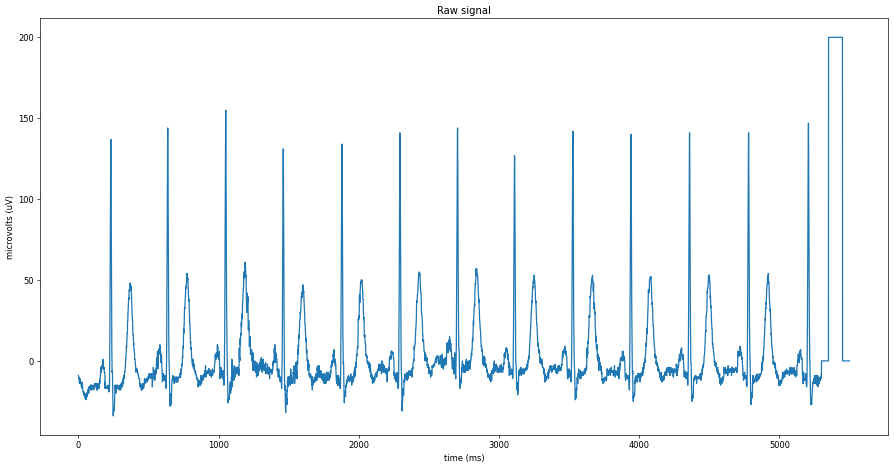

In [5]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

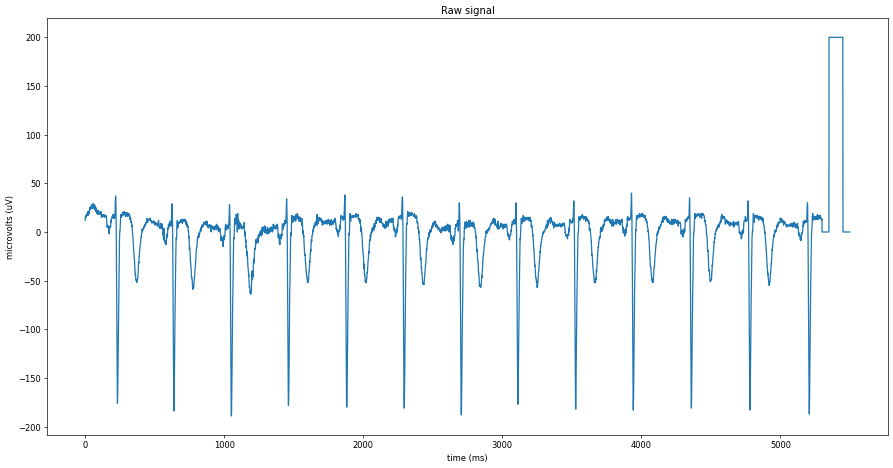

In [6]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[3])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

# Data normalization

In [7]:
mV = np.array(mV, dtype=float)
severity = np.array(severity, dtype=float)
lead = np.array(lead, dtype=float)

In [8]:
#como acceder a todas la derivaciones 1
#opción 1
mV[:,:1,:]
#opción 2
mV[lead == 0]

array([[ -9., -10., -11., ...,   0.,   0.,   0.],
       [-77., -70., -67., ...,   0.,   0.,   0.],
       [-79., -73., -69., ...,   0.,   0.,   0.],
       ...,
       [ 34.,  40.,  41., ...,   0.,   0.,   0.],
       [ -3.,  -2.,  -2., ...,   0.,   0.,   0.],
       [ -6., -11., -11., ...,   0.,   0.,   0.]])

In [9]:
scaler = preprocessing.MinMaxScaler()
mV = scaler.fit_transform(mV.reshape(-1, mV.shape[-1])).reshape(mV.shape)

# RNN LSTM building

In [10]:
X = mV
y = severity

In [11]:
print(X.shape)
print(y.shape)

(82, 12, 5500)
(82, 12)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(65, 12, 5500)
(65, 12)


In [13]:
lead_1_inp = Input((5500,1))
lead_1_LSTM = LSTM(20, return_sequences=True)(lead_1_inp)

lead_2_inp = Input((5500,1))
lead_2_LSTM = LSTM(20, return_sequences=True)(lead_2_inp)

lead_3_inp = Input((5500,1))
lead_3_LSTM = LSTM(20, return_sequences=True)(lead_3_inp)

lead_4_inp = Input((5500,1))
lead_4_LSTM = LSTM(20, return_sequences=True)(lead_4_inp)

lead_5_inp = Input((5500,1))
lead_5_LSTM = LSTM(20, return_sequences=True)(lead_5_inp)

lead_6_inp = Input((5500,1))
lead_6_LSTM = LSTM(20, return_sequences=True)(lead_6_inp)

lead_7_inp = Input((5500,1))
lead_7_LSTM = LSTM(20, return_sequences=True)(lead_7_inp)

lead_8_inp = Input((5500,1))
lead_8_LSTM = LSTM(20, return_sequences=True)(lead_8_inp)

lead_9_inp = Input((5500,1))
lead_9_LSTM = LSTM(20, return_sequences=True)(lead_9_inp)

lead_10_inp = Input((5500,1))
lead_10_LSTM = LSTM(20, return_sequences=True)(lead_10_inp)

lead_11_inp = Input((5500,1))
lead_11_LSTM = LSTM(20, return_sequences=True)(lead_11_inp)

lead_12_inp = Input((5500,1))
lead_12_LSTM = LSTM(20, return_sequences=True)(lead_12_inp)

In [14]:
concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])

h_1 = Dense(128)(concat)

o  = TimeDistributed(Dense(1, activation='sigmoid'))(h_1)

model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5500, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5500, 1)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5500, 1)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5500, 1)]    0                                            
______________________________________________________________________________________________

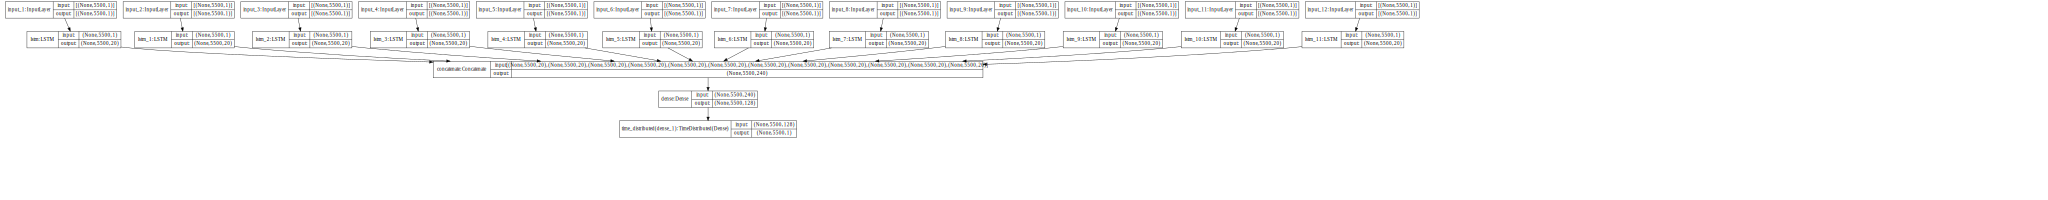

In [16]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [17]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
#Generamos un X_train con 12 inputs. Agrupando en 12 bloques, donde el número 0 contiene todas las ondias de la derivación 1,
# el número 1 contiene todas las ondas de la derivación 2 y así sucesivamente.
history = model.fit([X_train[:,:1,:].reshape(X_train.shape[0],5500,1), X_train[:,1:2,:].reshape(X_train.shape[0],5500,1), X_train[:,2:3,:].reshape(X_train.shape[0],5500,1), X_train[:,3:4,:].reshape(X_train.shape[0],5500,1), X_train[:,4:5,:].reshape(X_train.shape[0],5500,1), X_train[:,5:6,:].reshape(X_train.shape[0],5500,1), 
                    X_train[:,6:7,:].reshape(X_train.shape[0],5500,1), X_train[:,7:8,:].reshape(X_train.shape[0],5500,1), X_train[:,8:9,:].reshape(X_train.shape[0],5500,1), X_train[:,9:10,:].reshape(X_train.shape[0],5500,1), X_train[:,10:11,:].reshape(X_train.shape[0],5500,1), X_train[:,11:12,:].reshape(X_train.shape[0],5500,1)],
                    y_train[:,0],
                    batch_size=16, epochs=25,
                    validation_data=([X_test[:,:1,:].reshape(X_test.shape[0],5500,1), X_test[:,1:2,:].reshape(X_test.shape[0],5500,1), X_test[:,2:3,:].reshape(X_test.shape[0],5500,1), X_test[:,3:4,:].reshape(X_test.shape[0],5500,1), X_test[:,4:5,:].reshape(X_test.shape[0],5500,1), X_test[:,5:6,:].reshape(X_test.shape[0],5500).reshape(X_test.shape[0],5500,1), X_test[:,6:7,:].reshape(X_test.shape[0],5500,1), X_test[:,7:8,:].reshape(X_test.shape[0],5500,1), X_test[:,8:9,:].reshape(X_test.shape[0],5500,1), X_test[:,9:10,:].reshape(X_test.shape[0],5500,1), X_test[:,10:11,:].reshape(X_test.shape[0],5500,1), X_test[:,11:12,:].reshape(X_test.shape[0],5500,1)],y_test[:,0]))

Epoch 1/25
5/5 [==============================] - 24s 2s/step - loss: 0.6020 - accuracy: 0.7975 - val_loss: 0.3835 - val_accuracy: 0.8824
Epoch 2/25
5/5 [==============================] - 7s 1s/step - loss: 0.5381 - accuracy: 0.7884 - val_loss: 0.3764 - val_accuracy: 0.8824
Epoch 3/25
5/5 [==============================] - 7s 1s/step - loss: 0.5508 - accuracy: 0.7824 - val_loss: 0.4083 - val_accuracy: 0.8824
Epoch 4/25
5/5 [==============================] - 7s 1s/step - loss: 0.5843 - accuracy: 0.7433 - val_loss: 0.4531 - val_accuracy: 0.8824
Epoch 5/25
5/5 [==============================] - 7s 1s/step - loss: 0.5958 - accuracy: 0.7355 - val_loss: 0.4947 - val_accuracy: 0.8824
Epoch 6/25
5/5 [==============================] - 7s 1s/step - loss: 0.5642 - accuracy: 0.7720 - val_loss: 0.4528 - val_accuracy: 0.8824
Epoch 7/25
5/5 [==============================] - 7s 1s/step - loss: 0.5433 - accuracy: 0.7737 - val_loss: 0.4051 - val_accuracy: 0.8824
Epoch 8/25
5/5 [========================

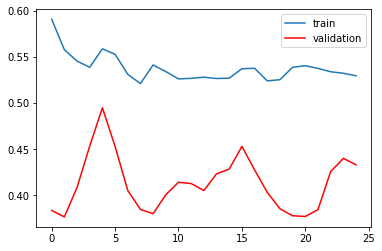

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],'r',label='validation')
plt.legend()

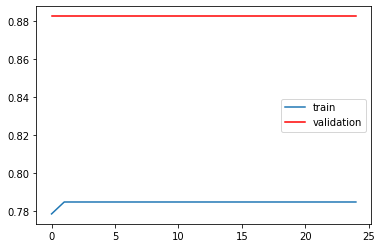

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],'r',label='validation')
plt.legend()